# **XGBoost** #

![XGBoost](https://upload.wikimedia.org/wikipedia/commons/6/69/XGBoost_logo.png)

A gradient-boosted regularized technique

## Introduction

In [1]:
import xgboost as xgb
f'Currently using XGBoost version: {xgb.__version__}'

'Currently using XGBoost version: 0.90'

This is going to be a cheatsheet for quick usage, not an extensive and deep one

### How does it work?

XGBoost minimizes a regularized (L1 and L2) objective function that combines a convex loss function (based on the difference between the predicted and target outputs) and a penalty term for model complexity (in other words, the regression tree functions).

As per specified at: https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-HowItWorks.html

### When not to use it?

- For Natural Language Processing (Text-to-voice, Speech recognizition, human understanding, analysis sentiment)
- When there are more features than samples
- Timeseries, it's not meant for those purposes

### How do we create XGBoost statistics models?

We can build simple models that we can train just like we'd do with sklearn models.

It provides an easy-to-understand API that we can configure.

### Data

For our datasets we'll use the sample data provided with Google Colab.

`/content/sample_data`

In [2]:
%cd /content/sample_data
%ls -la

/content/sample_data
total 55512
drwxr-xr-x 1 root root     4096 Jun 15 13:42 ./
drwxr-xr-x 1 root root     4096 Jun 15 13:42 ../
-rwxr-xr-x 1 root root     1697 Jan  1  2000 anscombe.json*
-rw-r--r-- 1 root root   301141 Jun 15 13:42 california_housing_test.csv
-rw-r--r-- 1 root root  1706430 Jun 15 13:42 california_housing_train.csv
-rw-r--r-- 1 root root 18289443 Jun 15 13:42 mnist_test.csv
-rw-r--r-- 1 root root 36523880 Jun 15 13:42 mnist_train_small.csv
-rwxr-xr-x 1 root root      930 Jan  1  2000 README.md*


## Helpers

Once stablished a little foundation, let's create some helpers specific to **XGBoost**.

### Imports

In [3]:
# basic
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# typing
from typing import List, Tuple

### Check for dataframe validity

We'll check for the already stablished rule

```python
is_valid = n_features < n_samples
```

Which translates to:

In [4]:
def is_dataframe_valid_for_xgboost(
  dataframe: pd.DataFrame
) -> bool:
  return len(dataframe.columns) < len(dataframe.index)

We can unit test it real quick

In [5]:
assert is_dataframe_valid_for_xgboost(pd.DataFrame([
  [1, 2, 3, 4, 5],
])) == False

In [6]:
assert is_dataframe_valid_for_xgboost(pd.DataFrame([
  [1, 1],
  [2, 2],
  [3, 3],
  [4, 4],
  [5, 5],
])) == True

### Feature imporances

The explainability of a model

In [7]:
def plot_feature_importance(
  dataframe: pd.DataFrame,
  booster_model,
  height_per_feature: float = .75,
  plot_width: float = 20,
  cmap: str = 'Blues',
  title: str = 'XGBoost - Feature importances',
) -> None:
  columns: List[str] = dataframe.columns
  n_columns = len(columns)

  df_importances = pd.DataFrame(
    data=zip( columns, booster_model.get_booster().get_score().values() ),
    columns=[ 'feature', 'importance' ],
  )
  df_importances['importance'] = df_importances['importance'] / df_importances['importance'].sum()
  sorted_df_importances = df_importances.sort_values(by='importance', ascending=False)

  plt.figure(figsize=(plot_width, n_columns * height_per_feature))
  plt.title(title, fontsize='x-large')
  plot = sns.barplot(data=sorted_df_importances, x='importance', y='feature', palette=sns.color_palette(cmap, n_columns)[::-1])

## Imports

Some common ground for both, regression and classification

In [8]:
# quality of life
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split

# normalization
from sklearn.preprocessing import MinMaxScaler

# feature reduction
from sklearn.decomposition import PCA

## Regression

Whenever we may want to predict a continue value ranged between [-Inf, +Inf]

### Imports

In [9]:
from xgboost import XGBRegressor, XGBRFRegressor

### Regression Dataset

We'll use the California Housing Pricing Dataset

In [10]:
df_regression = pd.read_csv('california_housing_train.csv')
df_regression_test = pd.read_csv('california_housing_test.csv')

In [11]:
assert is_dataframe_valid_for_xgboost(df_regression)

In [12]:
regression_train_columns = [ col for col in df_regression.columns if col != 'median_house_value' ]

In [13]:
X_regression_train = df_regression[ regression_train_columns ]
y_regression_train = df_regression['median_house_value']

In [14]:
X_regression_test = df_regression[ regression_train_columns ]
y_regression_test = df_regression['median_house_value']

### XGBRegressor

XGBRegressor is the "Linear Regressor" of XGBoost

In [15]:
def xgb_regressor() -> Pipeline:
  return make_pipeline(
    MinMaxScaler(),
    XGBRegressor(
      objective='reg:squarederror',
      verbose=1,
    ),
  )

In [16]:
xgb_regressor_model = xgb_regressor()
%time xgb_regressor_model.fit(X_regression_train, y_regression_train)
xgb_regressor_model.score(X_regression_test, y_regression_test)

CPU times: user 1.02 s, sys: 16.8 ms, total: 1.03 s
Wall time: 1.17 s


0.793430972170766

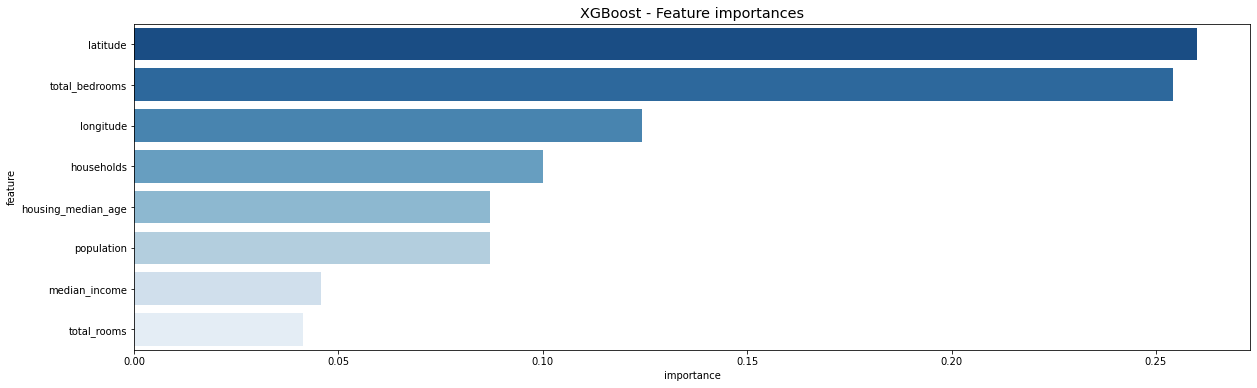

In [17]:
plot_feature_importance(X_regression_train, xgb_regressor_model['xgbregressor'])

### XGBRFRegressor

XGBRFRegressor is the Random Forest Regressor of XGBoost

In [18]:
def xgb_regressor_random_forest() -> Pipeline:
  return make_pipeline(
    MinMaxScaler(),
    XGBRFRegressor(
      objective='reg:squarederror',
      max_depth=50,
      n_estimators=25,
      verbose=1,
    ),
  )

In [19]:
xgb_regressor_random_forest_model = xgb_regressor_random_forest()
%time xgb_regressor_random_forest_model.fit(X_regression_train, y_regression_train)
xgb_regressor_random_forest_model.score(X_regression_test, y_regression_test)

CPU times: user 961 ms, sys: 3.51 ms, total: 965 ms
Wall time: 970 ms


0.831151296354632

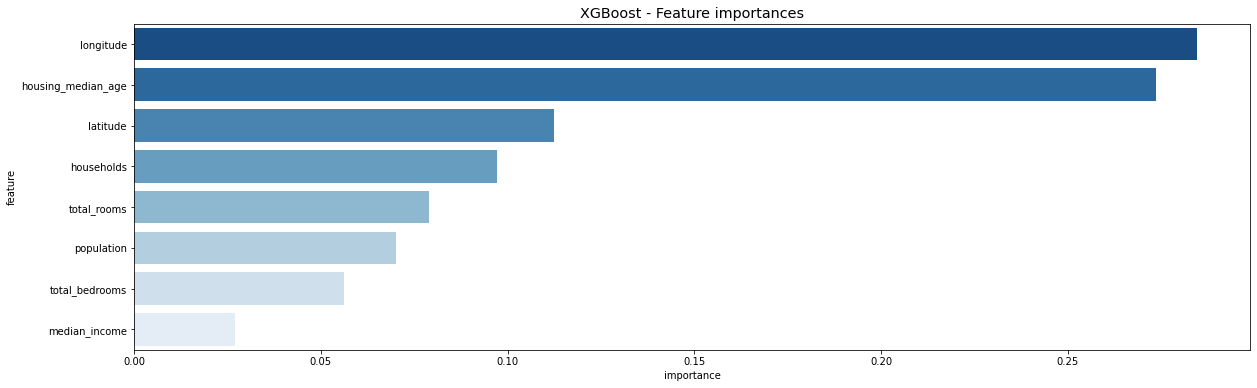

In [20]:
plot_feature_importance(X_regression_train, xgb_regressor_random_forest_model['xgbrfregressor'])

## Classification

Whenever we want to predict a discrete value with a defined range of options.

### Imports

In [21]:
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.metrics import confusion_matrix

# for the imbalancement
from imblearn.under_sampling import RandomUnderSampler

### Confusion Matrix

The confusion matrix doesn't change even if it's for XGBoost

In [22]:
def cmatrix(
  model: Pipeline,
  X_pred: pd.DataFrame,
  y_true: pd.DataFrame,
  cmap: str = 'Blues',
  y_pred: pd.DataFrame = None,
  figsize: Tuple[float, float] = (20, 15)
) -> None:
  if not y_pred:
    y_pred = model.predict(X_pred)

  df_cmatrix = confusion_matrix(y_true, y_pred)
  df_cmatrix = df_cmatrix / df_cmatrix.max()

  plt.figure(figsize=figsize)
  sns.heatmap(df_cmatrix, cmap=cmap, annot=True, annot_kws={'fontsize': 13}, fmt='.2g')

### Classification Dataset

We'll use the MNIST handwritten dataset

In [23]:
df_classification = pd.read_csv('mnist_train_small.csv', header=None)
df_classification_test = pd.read_csv('mnist_test.csv', header=None)

In [24]:
assert is_dataframe_valid_for_xgboost(df_classification)

In [25]:
classification_train_columns = df_classification_test.columns[1:]

In [26]:
X_classification_train = df_classification[classification_train_columns]
y_classification_train = df_classification[0]
X_classification_train, y_classification_train = RandomUnderSampler().fit_resample(X_classification_train, y_classification_train)

In [27]:
X_classification_test = df_classification_test[classification_train_columns]
y_classification_test = df_classification_test[0]

### Principal Component Analysis

Given that the MNIST includes so many features, we'll need to compress that information somehow to work faster, so let's just see how easy can we obtain a decent enough compression

In [28]:
PCA(25).fit(X_classification_train, y_classification_train).explained_variance_ratio_.sum()

0.6912798524152554

We'll configure it on a global variable

In [29]:
N_COMPONENTS = 25 #@param {type: 'integer'}

### XGBClassifier

XGBClassifier is the "Logistic Regressor" of XGBoost

In [30]:
def xgb_classifier(
  n_components: int = N_COMPONENTS
) -> Pipeline:
  return make_pipeline(
    MinMaxScaler(),
    PCA(n_components),
    XGBClassifier(),
  )

In [31]:
xgb_classifier_model = xgb_classifier()
%time xgb_classifier_model.fit(X_classification_train, y_classification_train)
xgb_classifier_model.score(X_classification_test, y_classification_test)

CPU times: user 38.7 s, sys: 1.14 s, total: 39.8 s
Wall time: 44.3 s


0.9036

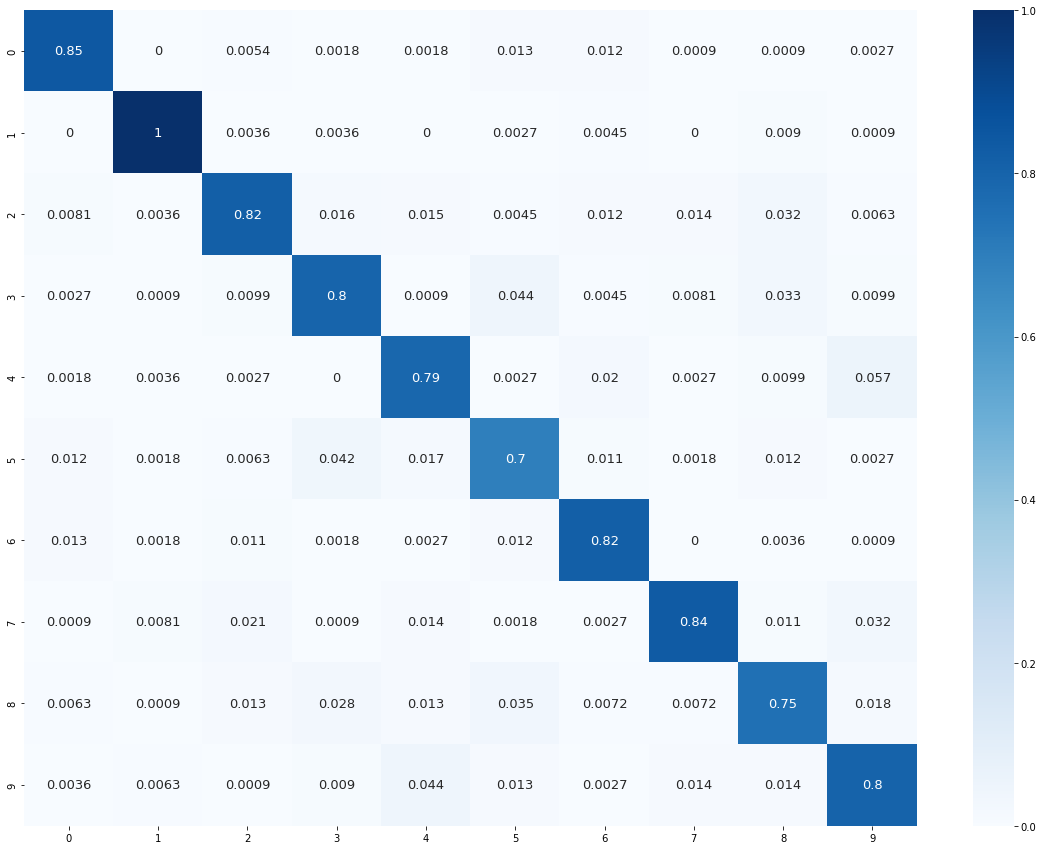

In [32]:
cmatrix(xgb_classifier_model, X_classification_test, y_classification_test)

### XGBRFClassifier

XGBRFClassifier is the Random Forest Classifier of XGBoost

In [33]:
def xgb_classifier_random_forest(
  n_components: int = N_COMPONENTS
) -> Pipeline:
  return make_pipeline(
    MinMaxScaler(),
    PCA(n_components),
    XGBRFClassifier(
      max_depth=50,
      n_estimators=25,
      verbose=1,
    ),
  )

In [34]:
xgb_classifier_random_forest_model = xgb_classifier_random_forest()
%time xgb_classifier_random_forest_model.fit(X_classification_train, y_classification_train)
xgb_classifier_random_forest_model.score(X_classification_test, y_classification_test)

CPU times: user 30 s, sys: 1.53 s, total: 31.6 s
Wall time: 29.6 s


0.907

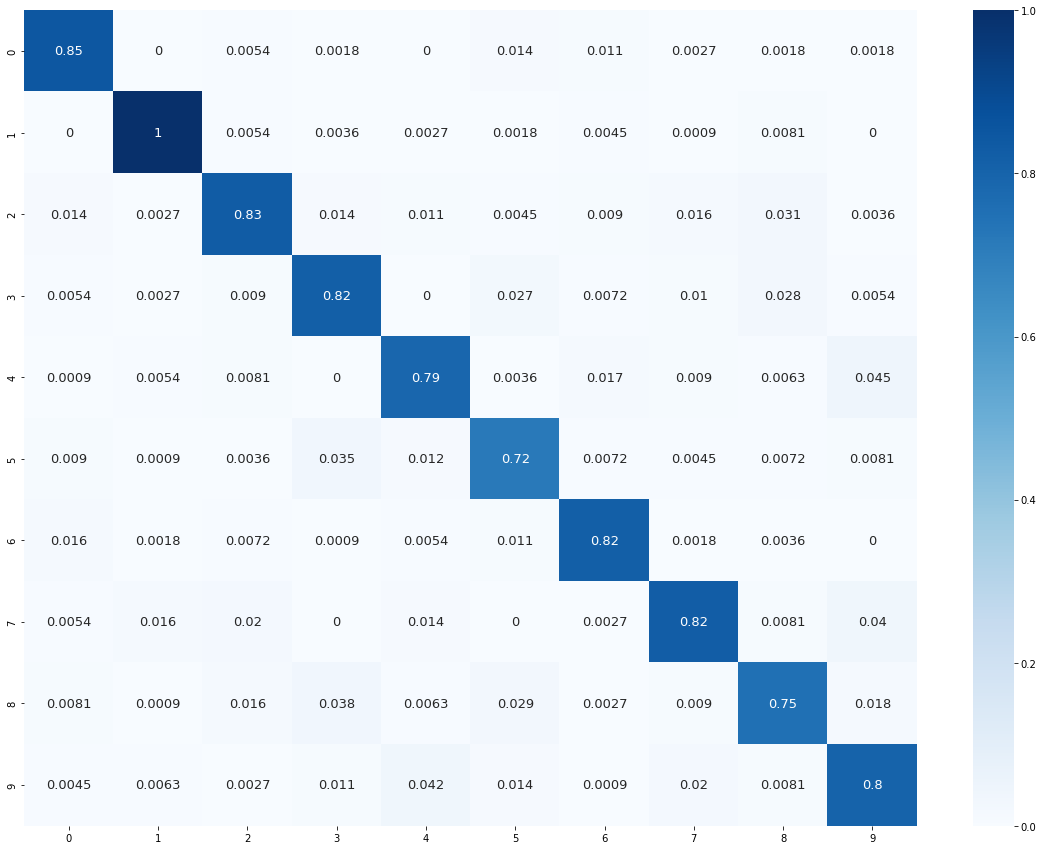

In [35]:
cmatrix(xgb_classifier_random_forest_model, X_classification_test, y_classification_test)